# ThaiCLIP guided VQGAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup, import and define stuffs

In [ ]:
#@title Setup and Imports (run this first)

print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning &> /dev/null

# Downloading the pre-trained VQGAN model weights:
print('Downloading ImageNet 16384 checkpoints')
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

print('Installing a few libraries')
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install einops                                       &> /dev/null

!git clone https://huggingface.co/airesearch/wangchanberta-base-att-spm-uncased
!git clone https://github.com/vistec-AI/thai2transformers

%cd /content/wangchanberta-base-att-spm-uncased/
!git lfs pull
%cd /content
!cp /content/thai2transformers/thai2transformers/preprocess.py /content

!pip install timm
!pip install transformers
!pip install sentencepiece
!pip install pythainlp
!pip install pythainlp[translate]
!pip install emoji

In [ ]:
#@title Import stuffs
import torch 
from torch import nn
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm

from CLIP import clip # The clip model
from torchvision import transforms # Some useful image transforms
import torch.nn.functional as F # Some extra methods we might need
from tqdm.notebook import tqdm # A progress bar library

from omegaconf import OmegaConf
import sys
sys.path.append('./taming-transformers')
from taming.models import cond_transformer, vqgan

import os
import cv2
import gc
import pandas as pd
import itertools
import albumentations as A
import matplotlib.pyplot as plt

import timm
from transformers import (
    CamembertModel,
    CamembertTokenizer,
    CamembertConfig,
)
from preprocess import process_transformers
from pythainlp.translate import Translate
from urllib.request import urlopen

from os.path import expanduser  # pylint: disable=import-outside-toplevel
from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel

In [ ]:
#@title Helper function
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply

def vector_quantize(x, codebook):
  d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
  indices = d.argmin(-1)
  x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
  return replace_grad(x_q, x)

def synth(z):
  z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
  return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def rand_z(width, height):
  f = 2**(model.decoder.num_resolutions - 1)
  toksX, toksY = width // f, height // f
  n_toks = model.quantize.n_e
  one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
  z = one_hot @ model.quantize.embedding.weight
  z = z.view([-1, toksY, toksX, model.quantize.e_dim]).permute(0, 3, 1, 2)
  return z

def clip_loss(im_embed, text_embed):
  im_normed = F.normalize(im_embed.unsqueeze(1), dim=2)
  text_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
  dists = im_normed.sub(text_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
  return dists.mean()

def get_aesthetic_model(clip_model="vit_l_14"):
    """load the aethetic model"""
    home = expanduser("~")
    cache_folder = home + "/.cache/emb_reader"
    path_to_model = cache_folder + "/sa_0_4_"+clip_model+"_linear.pth"
    if not os.path.exists(path_to_model):
        os.makedirs(cache_folder, exist_ok=True)
        url_model = (
            "https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_"+clip_model+"_linear.pth?raw=true"
        )
        urlretrieve(url_model, path_to_model)
    if clip_model == "vit_l_14":
        m = nn.Linear(768, 1)
    elif clip_model == "vit_b_32":
        m = nn.Linear(512, 1)
    else:
        raise ValueError()
    s = torch.load(path_to_model)
    m.load_state_dict(s)
    m.eval()
    return m

In [ ]:
#@title Model class
class CFG:
    # captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    text_encoder_model = "/content/wangchanberta-base-att-spm-uncased"
    text_embedding = 768
    text_tokenizer = "/content/wangchanberta-base-att-spm-uncased"
    max_length = 200

    pretrained = True
    trainable = True
    temperature = 1.0

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 512 
    dropout = 0.1

class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = CamembertModel.from_pretrained(model_name)
        else:
            self.model = CamembertModel(config=CamembertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

class TextModel(nn.Module):
    def __init__(
        self,
        text_embedding = CFG.text_embedding
    ):
        super().__init__()
        self.text_encoder = TextEncoder()
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.tokenizer = CamembertTokenizer.from_pretrained(CFG.text_tokenizer)

    def forward(self, batch):
        # Getting Text Features
        text_features = self.text_encoder(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        # Project to the same dim of image encoder
        text_embeddings = self.text_projection(text_features)

        return text_embeddings
    
    def encode_text(self, text):
        tokened_word = self.tokenizer(text, padding=True, truncation=True, max_length=CFG.max_length)
        text_features = self.text_encoder(
            input_ids=torch.tensor(tokened_word["input_ids"]).to(CFG.device),
            attention_mask=torch.tensor(tokened_word["attention_mask"]).to(CFG.device)
        )
        text_embeddings = self.text_projection(text_features)
        return text_embeddings

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                # A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

# Load Model

In [ ]:
clip_model, compose = clip.load('ViT-B/32')

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 195MiB/s]


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = load_vqgan_model('vqgan_imagenet_f16_16384.yaml', 'vqgan_imagenet_f16_16384.ckpt').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 432kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


In [ ]:
text_model = TextModel().to(CFG.device)
text_model.load_state_dict(torch.load("/content/drive/MyDrive/text_MSE_2m.pt", map_location=CFG.device))
text_model.eval().requires_grad_(False)
...

Some weights of the model checkpoint at /content/wangchanberta-base-att-spm-uncased were not used when initializing CamembertModel: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Ellipsis

In [ ]:
amodel= get_aesthetic_model(clip_model="vit_b_32").to(CFG.device)
amodel.eval()

Linear(in_features=512, out_features=1, bias=True)

# Test that it actually works!

In [ ]:
with torch.no_grad():
    language_embs = text_model.encode_text(['สวัสดี'])
    # image_embs = clip_model.encode_image(img_input).float().to('cpu')

language_embs.shape

torch.Size([1, 512])

In [ ]:
im = torch.rand(1, 3, 224, 224)

normalize = transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))

image_embed = clip_model.encode_image(normalize(im).to(device))
image_embed.shape

torch.Size([1, 512])

In [ ]:
# im = Image.open('/content/3e4ba541cdc845a3bafd39b80cb7b672-2.jpg').convert('RGB').resize((224, 224))
# im = torch.tensor(np.array(im)).permute(2, 0, 1)/255
# im = im.unsqueeze(0).to(device)

# with torch.no_grad():
#   image_embed = clip_model.encode_image(normalize(im).to(device)).float()
#   image_embed /= image_embed.norm(dim=-1, keepdim=True)
#   prediction = amodel(image_embed)
#   print(prediction[0, 0])

# GANS + CLIP

In [ ]:
torch.cuda.empty_cache()

rm: cannot remove 'steps': No such file or directory


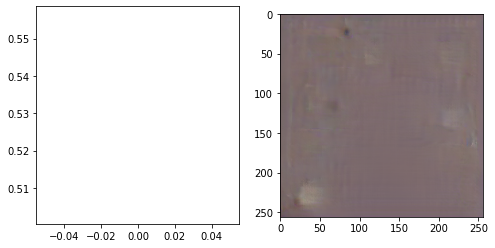

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
from IPython.display import Image as Images

prompt_text = "\u0E23\u0E16\u0E44\u0E1F \u0E20\u0E32\u0E1E\u0E04\u0E21\u0E0A\u0E31\u0E14" #@param {type:"string"}
negative_prompt = "\u0E20\u0E32\u0E1E\u0E40\u0E1A\u0E25\u0E2D" #@param {type:"string"}
neg_weight = 0.4#@param
width =  256#@param
height =  256#@param
aesthetic_weight = 0.005#@param
init_image = ""#@param {type:"string"}
target_image = ""#@param {type:"string"}
tar_weight = 0#@param
lr = 0.1 #@param
n_iter =  300#@param
crops_per_iteration =  8#@param

# The transforms to get variations of our image
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAdjustSharpness(1), # game changer
    # transforms.RandomAutocontrast(),
    # transforms.RandomEqualize(),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(3),
])

if target_image:
    if 'http' in target_image:
      img = Image.open(urlopen(target_image)).convert('RGB').resize((224, 224))
    else:
      img = Image.open(target_image).convert('RGB').resize((224, 224))
    im = torch.tensor(np.array(img)).permute(2, 0, 1)/255
    im = im.unsqueeze(0).to(device)
    with torch.no_grad():
        tar_embed = clip_model.encode_image(normalize(im).to(device)).float()

# The z we'll be optimizing
if init_image:
    if 'http' in init_image:
      img = Image.open(urlopen(init_image)).convert('RGB').resize((width, height))
    else:
      img = Image.open(init_image).convert('RGB').resize((width, height))
    im = torch.tensor(np.array(img)).permute(2, 0, 1)/255
    im = im.unsqueeze(0).to(device)
    z, *_ = model.encode(im)
else:
    z = rand_z(width, height)
z.requires_grad=True

# The text target
with torch.no_grad():
    text_embed = text_model.encode_text([process_transformers(prompt_text)]).to(device).float()
    neg_text_embed = text_model.encode_text([process_transformers(negative_prompt)]).to(device).float()

# The optimizer - feel free to try different ones here
optimizer = torch.optim.Adam([z], lr=lr, weight_decay=1e-6)

losses = [] # Keep track of our losses (RMSE values)

# A folder to save results
!rm -r steps
!mkdir steps


# Display for showing progress
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
p = display(fig, display_id=True)

# The optimization loop:
for i in tqdm(range(n_iter)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Get the GAN output
  output = synth(z)

  # Calculate our loss across several different random crops/transforms
  loss = 0
  for _ in range(crops_per_iteration):
    image_embed = clip_model.encode_image(normalize(tfms(output)).to(device)).float()
    # text-image loss
    loss += clip_loss(image_embed, text_embed)/crops_per_iteration
    # text-image neg loss
    loss -= (neg_weight * clip_loss(image_embed, neg_text_embed))/crops_per_iteration
    # aesthetic weight loss
    loss -= (aesthetic_weight * amodel(image_embed/image_embed.norm(dim=-1, keepdim=True))[0, 0])/crops_per_iteration
    # target image loss
    if target_image:
        loss += (tar_weight * clip_loss(image_embed, tar_embed))/crops_per_iteration

  # Store loss
  losses.append(loss.detach().item())

  # Save image
  im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)
  Image.fromarray(im_arr).save(f'steps/{i:04}.jpeg')

  # Update plots 
  if i % 5 == 0: # Saving time
    axs[0].plot(losses)
    axs[1].imshow(im_arr)
    p.update(fig)

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

# ipd.clear_output()
display(Images('/content/steps/0299.jpeg'))

In [ ]:
#@title Show Video
!ffmpeg -v 0 -y -f image2 -framerate 30 -i steps/%04d.jpeg -c:v h264_nvenc -preset slow -qp 18 -pix_fmt yuv420p progress_video.mp4
from IPython.display import HTML
from base64 import b64encode
mp4 = open('progress_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=512 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

You can download the video and specific output frames from the files pane on the left. What can you make?